<a href="https://colab.research.google.com/github/pvilas/fotovoltaica/blob/main/Producci%C3%B3n_vs_consumo_de_una_instalaci%C3%B3n_fotovoltaica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Producción y consumo de una instalación fotovoltáica

Con este cuaderno es posible calcular, a partir de los datos que pueden descargarse en endesa o energiaxxi, el consumo horario medio de un periodo y compararlo con la generación posible para el mismo.

De la anterior comparación horaria, será posible determinar si nos es rentable la instalación de un sistema de autoconsumo.

Como usamos la base de datos de radiación de pvgis, los cálculos sólo pueden realizarse para España (Península e Illes Balears). Es importante hacer notar que pasamos esos datos a horario CET, sumando directamente una hora al GMT. 
Por lo tanto, los cálculos de radiación en horario de verano estarán retrasados una hora respecto al horario civil.

Para más explicaciones, ver el vídeo de youtube.

Si encuentra algún error, te ruego que lo comentes en issues o hagas un pull request.

## Bibliotecas

In [6]:
!pip install pvlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.6 MB 1.6 MB/s 


In [7]:
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import pvlib
import pytz
from datetime import datetime as dt, timezone

In [38]:
# comprobaciones de la zona horaria ya que los datos de pvgis vienen en UTC
# Retrieve the current date
current_date = dt.now(timezone.utc)
# Print the current data and time
print(f'Fecha y local en UTC {current_date}')

zona_horaria='Europe/Madrid'
# zona horaria CET
CET = pytz.timezone(zona_horaria)

print(f"Fecha y hora local en {zona_horaria}: {current_date.astimezone(CET).isoformat()}")
# Read the datetime of the specified timezone
#print('\nDatetime of UTC Time-zone: ', dt.datetime.now(tz=currentTimeZone))
#print('Datetime of IST Time-zone: ', dt.datetime.now(tz=newTimeZone))


Fecha y local en UTC 2022-09-14 11:53:59.228573+00:00
Fecha y hora local en Europe/Madrid: 2022-09-14T13:53:59.228573+02:00


## Datos de consumo
Hacer copiar/pegar del fichero que se genera en la página de Endesa. No incluir las cabeceras. Conservar las comillas iniciales y finales.

Si tienes la **tarifa 2.0 TD**, el formato es el siguiente:

|Fecha	|Hora	Consumo (Wh)|	Precio (€/kWh)	|Coste por hora (€)|
| - | -| -| -|
|2022-03-16	|1.0	|99.0	|0.320903126	|0.031769409474|
|2022-03-16	|2.0	|233.0	|0.321571182|	0.074926085406|
|2022-03-16	|3.0	|244.0	|0.321575397|	0.078464396868|

Si tienes la **tarifa happy** el formato es:

|Fecha	|Hora	|Consumo (Wh)	|Hora Happy|
| - | - | - | - |
|2022-09-06	|00:00-01:00	|877.0	|No|
|2022-09-06	|01:00-02:00	|211.0	|No|
|2022-09-06	|02:00-03:00	|1591.0	|No|

In [2]:
datos_raw_td="""
2022-03-16 , 1.0 , 99.0 , 0.320903126 , 0.031769409474
2022-03-16 , 2.0 , 233.0 , 0.321571182 , 0.074926085406
2022-03-16 , 3.0 , 244.0 , 0.321575397 , 0.078464396868
2022-03-16 , 4.0 , 82.0 , 0.307665373 , 0.025228560586
2022-03-16 , 5.0 , 86.0 , 0.305615173 , 0.026282904878
2022-03-16 , 6.0 , 86.0 , 0.320287681 , 0.027544740566
2022-03-16 , 7.0 , 112.0 , 0.359730695 , 0.040289837839999995
2022-03-16 , 8.0 , 574.0 , 0.372247307 , 0.213669954218
2022-03-16 , 9.0 , 514.0 , 0.409696453 , 0.210583976842
2022-03-16 , 10.0 , 608.0 , 0.387379082 , 0.235526481856
2022-03-16 , 11.0 , 593.0 , 0.431872038 , 0.256100118534
2022-03-16 , 12.0 , 92.0 , 0.418028152 , 0.038458589984
2022-03-16 , 13.0 , 82.0 , 0.42414929 , 0.034780241780000005
2022-03-16 , 14.0 , 89.0 , 0.423840498 , 0.037721804322
2022-03-16 , 15.0 , 385.0 , 0.361578055 , 0.139207551175
2022-03-16 , 16.0 , 182.0 , 0.361672672 , 0.065824426304
2022-03-16 , 17.0 , 746.0 , 0.353498463 , 0.263709853398
2022-03-16 , 18.0 , 168.0 , 0.364375058 , 0.061215009743999994
"""

# copiar/pegar aquí los consumos
datos_raw="""
2022-09-06 , 00:00-01:00 , 877.0 , No 
2022-09-06 , 01:00-02:00 , 211.0 , No 
2022-09-06 , 02:00-03:00 , 1591.0 , No 
2022-09-06 , 03:00-04:00 , 2043.0 , No 
2022-09-06 , 04:00-05:00 , 787.0 , No 
2022-09-06 , 05:00-06:00 , 348.0 , No 
2022-09-06 , 06:00-07:00 , 1339.0 , No 
2022-09-06 , 07:00-08:00 , 2197.0 , No 
2022-09-06 , 08:00-09:00 , 1378.0 , No 
2022-09-06 , 09:00-10:00 , 1354.0 , No 
2022-09-06 , 10:00-11:00 , 1158.0 , No 
2022-09-06 , 11:00-12:00 , 320.0 , No 
2022-09-06 , 12:00-13:00 , 1386.0 , No 
2022-09-06 , 13:00-14:00 , 1830.0 , No 
2022-09-06 , 14:00-15:00 , 629.0 , No 
2022-09-06 , 15:00-16:00 , 1573.0 , No 
2022-09-06 , 16:00-17:00 , 5517.0 , Sí 
2022-09-06 , 17:00-18:00 , 7082.0 , Sí 
2022-09-06 , 18:00-19:00 , 7708.0 , Sí 
2022-09-06 , 19:00-20:00 , 999.0 , No 
2022-09-06 , 20:00-21:00 , 508.0 , No 
2022-09-06 , 21:00-22:00 , 1883.0 , No 
2022-09-06 , 22:00-23:00 , 798.0 , No 
2022-09-06 , 23:00-00:00 , 385.0 , No 

2022-09-07 , 00:00-01:00 , 1037.0 , No 
2022-09-07 , 01:00-02:00 , 415.0 , No 
2022-09-07 , 02:00-03:00 , 1695.0 , No 
2022-09-07 , 03:00-04:00 , 1650.0 , No 
2022-09-07 , 04:00-05:00 , 707.0 , No 
2022-09-07 , 05:00-06:00 , 236.0 , No 
2022-09-07 , 06:00-07:00 , 1247.0 , No 
2022-09-07 , 07:00-08:00 , 1997.0 , No 
2022-09-07 , 08:00-09:00 , 1145.0 , No 
2022-09-07 , 09:00-10:00 , 1292.0 , No 
2022-09-07 , 10:00-11:00 , 650.0 , No 
2022-09-07 , 11:00-12:00 , 226.0 , No 
2022-09-07 , 12:00-13:00 , 1383.0 , No 
2022-09-07 , 13:00-14:00 , 1763.0 , No 
2022-09-07 , 14:00-15:00 , 626.0 , No 
2022-09-07 , 15:00-16:00 , 1498.0 , No 
2022-09-07 , 16:00-17:00 , 1300.0 , No 
2022-09-07 , 17:00-18:00 , 394.0 , No 
2022-09-07 , 18:00-19:00 , 1429.0 , No 
2022-09-07 , 19:00-20:00 , 909.0 , No 
2022-09-07 , 20:00-21:00 , 762.0 , No 
2022-09-07 , 21:00-22:00 , 2112.0 , No 
2022-09-07 , 22:00-23:00 , 1190.0 , No 
2022-09-07 , 23:00-00:00 , 348.0 , No 

2022-09-08 , 00:00-01:00 , 949.0 , No 
2022-09-08 , 01:00-02:00 , 357.0 , No 
2022-09-08 , 02:00-03:00 , 1751.0 , No 
2022-09-08 , 03:00-04:00 , 1692.0 , No 
2022-09-08 , 04:00-05:00 , 662.0 , No 
2022-09-08 , 05:00-06:00 , 147.0 , No 
2022-09-08 , 06:00-07:00 , 1170.0 , No 
2022-09-08 , 07:00-08:00 , 1864.0 , No 
2022-09-08 , 08:00-09:00 , 1584.0 , No 
2022-09-08 , 09:00-10:00 , 1991.0 , No 
2022-09-08 , 10:00-11:00 , 633.0 , No 
2022-09-08 , 11:00-12:00 , 229.0 , No 
2022-09-08 , 12:00-13:00 , 1293.0 , No 
2022-09-08 , 13:00-14:00 , 1661.0 , No 
2022-09-08 , 14:00-15:00 , 605.0 , No 
2022-09-08 , 15:00-16:00 , 1328.0 , No 
2022-09-08 , 16:00-17:00 , 1472.0 , No 
2022-09-08 , 17:00-18:00 , 850.0 , No 
2022-09-08 , 18:00-19:00 , 1376.0 , No 
2022-09-08 , 19:00-20:00 , 525.0 , No 
2022-09-08 , 20:00-21:00 , 1933.0 , No 
2022-09-08 , 21:00-22:00 , 6353.0 , Sí 
2022-09-08 , 22:00-23:00 , 2369.0 , No 
2022-09-08 , 23:00-00:00 , 6923.0 , Sí 

2022-09-09 , 00:00-01:00 , 6151.0 , Sí 
2022-09-09 , 01:00-02:00 , 234.0 , No 
2022-09-09 , 02:00-03:00 , 1904.0 , No 
2022-09-09 , 03:00-04:00 , 1699.0 , No 
2022-09-09 , 04:00-05:00 , 649.0 , No 
2022-09-09 , 05:00-06:00 , 225.0 , No 
2022-09-09 , 06:00-07:00 , 1236.0 , No 
2022-09-09 , 07:00-08:00 , 2090.0 , No 
2022-09-09 , 08:00-09:00 , 1050.0 , No 
2022-09-09 , 09:00-10:00 , 1243.0 , No 
2022-09-09 , 10:00-11:00 , 1188.0 , No 
2022-09-09 , 11:00-12:00 , 408.0 , No 
2022-09-09 , 12:00-13:00 , 1285.0 , No 
2022-09-09 , 13:00-14:00 , 2059.0 , No 
2022-09-09 , 14:00-15:00 , 828.0 , No 
2022-09-09 , 15:00-16:00 , 1605.0 , No 
2022-09-09 , 16:00-17:00 , 1468.0 , No 
2022-09-09 , 17:00-18:00 , 343.0 , No 
2022-09-09 , 18:00-19:00 , 1295.0 , No 
2022-09-09 , 19:00-20:00 , 572.0 , No 
2022-09-09 , 20:00-21:00 , 449.0 , No 
2022-09-09 , 21:00-22:00 , 1209.0 , No 
2022-09-09 , 22:00-23:00 , 536.0 , No 
2022-09-09 , 23:00-00:00 , 225.0 , No 

2022-09-10 , 00:00-01:00 , 1001.0 , No 
2022-09-10 , 01:00-02:00 , 362.0 , No 
2022-09-10 , 02:00-03:00 , 1662.0 , No 
2022-09-10 , 03:00-04:00 , 1737.0 , No 
2022-09-10 , 04:00-05:00 , 1007.0 , No 
2022-09-10 , 05:00-06:00 , 302.0 , No 
2022-09-10 , 06:00-07:00 , 1286.0 , No 
2022-09-10 , 07:00-08:00 , 1757.0 , No 
2022-09-10 , 08:00-09:00 , 984.0 , No 
2022-09-10 , 09:00-10:00 , 1233.0 , No 
2022-09-10 , 10:00-11:00 , 637.0 , No 
2022-09-10 , 11:00-12:00 , 527.0 , No 
2022-09-10 , 12:00-13:00 , 1335.0 , No 
2022-09-10 , 13:00-14:00 , 2398.0 , No 
2022-09-10 , 14:00-15:00 , 1043.0 , No 
2022-09-10 , 15:00-16:00 , 1452.0 , No 
2022-09-10 , 16:00-17:00 , 1477.0 , No 
2022-09-10 , 17:00-18:00 , 581.0 , No 
2022-09-10 , 18:00-19:00 , 1475.0 , No 
2022-09-10 , 19:00-20:00 , 1582.0 , No 
2022-09-10 , 20:00-21:00 , 2008.0 , No 
2022-09-10 , 21:00-22:00 , 2516.0 , Sí 
2022-09-10 , 22:00-23:00 , 7813.0 , Sí 
2022-09-10 , 23:00-00:00 , 1223.0 , No 

"""

## Parámetros de la instalación fotovoltaica

Los parámetros para el cálculo son los siguientes:

- lat: Latitude of the location
- lon: Longitude of the location
- name: Name of the panel location on the object
- tilt: Tilt of the solar panels (0 is flat, 90 is standing straight)
- azimuth: Direction the panels, 0 is South, negative from south to east, - positive from south to west
- panels: Number of panels on the location
- peakpower: Peakpower per panel (in kW)

### Consideraciones

1. La longitud y latitud se puede sacar del google maps. Hay que poner todos los decimales. También puede ser interesante [modelizar las sombras](https://shadowclaculator.eu), especialmente en los solsticios y el equinocio.
2. La fecha de inicio y final la toma del mínimo y máximo de los datos de consumo.
3. Los datos de producción se ajustarán automáticamente a la zona horaria seleccionada. `Europe/Madrid` es adecuado para la Península e Illes Balears, `Atlantic/Canary` para las Islas Canarias.

> Atención: La base de datos pvgis sólo llega hasta 2020. Hemos tomado los **datos de radiación de este año 2020 como base** para la comparación con el consumo de cualquier año.

In [51]:
lat=38.908688333675734
lon=1.4240844998325475

name="Mi vivienda" # nombre descriptivo para el gráfico
tilt=30 # inclinación de los paneles en grados (0 plano horizontal, 90 de pie)
azimut=-5 # acimut (0 es orientado al Sur, negativo hacia el E, positivo hacia 0)
panels=8 # número de paneles
peakpower=0.405 # potencia pico de los paneles en kW


zona_horaria='Europe/Madrid' #	Atlantic/Canary
# zona horaria
CET = pytz.timezone(zona_horaria)

## Procesado de datos de consumo

Cargamos y comprobamos.

In [40]:
print('Iniciando carga de datos')
import re
tarifa_happy=False
# determinamos el formato de los datos
# buscamos una linea no vacía y comprobamos si el inicio de linea se corresponde con algo como
# 2022-09-06 , 00:00-01:00 
# en caso positivo los datos de consumo están en formato tarifa happy
for l in datos_raw.splitlines():
  if l!='':
    if re.search("^([0-9]{4})(-)([0-9]{2})(-)([0-9]{2})\s(,)\s([0-9]{2})(:)([0-9]{2})(-)([0-9]{2})(:)([0-9]{2})\s", l):
      tarifa_happy=True


print(f"Tarifa happy: {tarifa_happy}")

if tarifa_happy:
  # Fecha  , Hora  , Consumo (Wh) , Hora Happy
  df = pd.read_csv(StringIO(datos_raw), 
                  names=["fecha", "hora_str", "consumo", "hora-happy"],
                  dtype={"fecha": object, "hora_str": str, "consumo": np.float64, "hora-happy": str},
                  parse_dates=["fecha"],)
  # parseamos la hora para hacerla compatible con el formato td, o sea 1.0 = 00:00-01:00
  df['hora']=df['hora_str'].astype(str).str[0:3].astype(np.float64)+1
  
else: # tarifa td
  # Fecha  , Hora  , Consumo (Wh) , Precio (€/kWh) , Coste por hora (€)
  df = pd.read_csv(StringIO(datos_raw), 
                  names=["fecha", "hora", "consumo", "precio", "coste-hora"],
                  dtype={"fecha": object, "hora": "Int64", "consumo": "Int64", "precio": np.float64, "coste-hora": np.float64},
                  parse_dates=["fecha"],) 
#df.columns=["fecha", "hora", "consumo", "precio", "coste-hora"]
#df.dtype={"fecha": object, "hora": "Int64", "consumo": "Int64", "precio": np.float64, "coste-hora": np.float64}
print(f'Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas')
print(df.head(10))
print('...')

Iniciando carga de datos
Tarifa happy: True
Datos cargados: 120 filas, 5 columnas
       fecha       hora_str  consumo hora-happy  hora
0 2022-09-06   00:00-01:00     877.0        No    1.0
1 2022-09-06   01:00-02:00     211.0        No    2.0
2 2022-09-06   02:00-03:00    1591.0        No    3.0
3 2022-09-06   03:00-04:00    2043.0        No    4.0
4 2022-09-06   04:00-05:00     787.0        No    5.0
5 2022-09-06   05:00-06:00     348.0        No    6.0
6 2022-09-06   06:00-07:00    1339.0        No    7.0
7 2022-09-06   07:00-08:00    2197.0        No    8.0
8 2022-09-06   08:00-09:00    1378.0        No    9.0
9 2022-09-06   09:00-10:00    1354.0        No   10.0
...


## Análisis de los consumos

Sacamos varias estadísticas de consumo.

In [41]:
desde=df.fecha.min()
fins=df.fecha.max()
dias=df.fecha.nunique()
fileres=df.shape[0]

# Atención: las fechas deben estar entre 2005 y 2020
# en este caso, le cambiamos el año a las fechas de inicio y final
str_start=f'2020-{desde.month:02}-{desde.day:02}'
start=pd.Timestamp(str_start)
str_fins=f'2020-{fins.month:02}-{fins.day:02}'
end=pd.Timestamp(str_fins)


print(f'\nConsumos periodo desde {desde:%Y-%m-%d} hasta {fins:%Y-%m-%d} ({dias}) días.')
print(f"")
#print("-"*80)

print(f'\nConsumo total por hora del periodo [Wh]')
hores=df.groupby(["hora"])['consumo'].sum() # suma de consums per hora
print(hores)
total_consumo=hores.sum()
print(f'Total consumo periodo: {total_consumo} Wh')


print(f'\nConsumo medio por hora [Wh]')
consumo_medio_hora=df.groupby(["hora"])['consumo'].mean()
print(consumo_medio_hora)



Consumos periodo desde 2022-09-06 hasta 2022-09-10 (5) días.


Consumo total por hora del periodo [Wh]
hora
1.0     10015.0
2.0      1579.0
3.0      8603.0
4.0      8821.0
5.0      3812.0
6.0      1258.0
7.0      6278.0
8.0      9905.0
9.0      6141.0
10.0     7113.0
11.0     4266.0
12.0     1710.0
13.0     6682.0
14.0     9711.0
15.0     3731.0
16.0     7456.0
17.0    11234.0
18.0     9250.0
19.0    13283.0
20.0     4587.0
21.0     5660.0
22.0    14073.0
23.0    12706.0
24.0     9104.0
Name: consumo, dtype: float64
Total consumo periodo: 176978.0 Wh

Consumo medio por hora [Wh]
hora
1.0     2003.0
2.0      315.8
3.0     1720.6
4.0     1764.2
5.0      762.4
6.0      251.6
7.0     1255.6
8.0     1981.0
9.0     1228.2
10.0    1422.6
11.0     853.2
12.0     342.0
13.0    1336.4
14.0    1942.2
15.0     746.2
16.0    1491.2
17.0    2246.8
18.0    1850.0
19.0    2656.6
20.0     917.4
21.0    1132.0
22.0    2814.6
23.0    2541.2
24.0    1820.8
Name: consumo, dtype: float64


Ahora, analizamos los consumos realizados dentro de cada uno de los tramos de tarificación de la compañía: Punta, Llano y Valle.

In [45]:
# tramos de facturación, el resto de variables son de apoyo
periodes_facturacio={
    "Punta": { "tramos": [(10, 14), (18, 22)], "consumo": 0, "num_horas": 0, "precio": 0.0},
    "Llano": { "tramos": [(8, 10), (14, 18), (22, 24)], "consumo": 0, "num_horas": 0, "precio": 0.0},
    "Valle": { "tramos": [(0, 8)], "consumo": 0,  "num_horas": 0, "precio": 0.0}
}

print(f'Consumos por tramo de tarificación')
fto_tabla_consumos="{:<15} {:>10} {:>15} {:>15}"# {:>15}"
print(fto_tabla_consumos.format("Tramo","Horas [h]", "Consumo [kWh]", "Porcentaje")) #, "Precio medio [€/kWh]"))
# feim uns slices segons els periodes de facturació
for period in periodes_facturacio.keys():
    #print(f'{period}')
    periodes_facturacio[period]["num_horas"]=0 
    # periodes_facturacio[period]["precio"]=0.0   
    for tramo in periodes_facturacio[period]["tramos"]:
        inicio_tramo=tramo[0]
        fin_tramo=tramo[1]-1
        num_horas=fin_tramo-inicio_tramo+1 # nombre d'hores del tram
        # print(f"{period} {tramo} indice ({inicio_tramo}:{fin_tramo}) num_horas: {num_horas}")
        tr=hores[inicio_tramo:fin_tramo+1] # slice de los consumos de las horas del tramo
        # print(f'{tr}')
        # acumulam el consum del tram
        periodes_facturacio[period]["consumo"]=periodes_facturacio[period]["consumo"]+tr.sum()
        """
        tp=preus[inicio_tramo:fin_tramo+1] # preus del tram
        periodes_facturacio[period]["precio"]=periodes_facturacio[period]["precio"]+tp.precio.sum()
        """
        periodes_facturacio[period]["num_horas"]=periodes_facturacio[period]["num_horas"]+num_horas        
        # periodes_facturacio[period]["precio"]=periodes_facturacio[period]["precio"]+precio_medio_hora[inicio_tramo:fin_tramo+1].sum()
        #print(f'Total tramo {tramo} ({num_horas} horas): {tr.sum()}')
        #print('\n')    
    print(fto_tabla_consumos.format( 
                period, 
                periodes_facturacio[period]['num_horas'],
                f"{periodes_facturacio[period]['consumo']/1000:.3f}",
                f"{(periodes_facturacio[period]['consumo']*100/total_consumo):.0f}") #,
                #f"{periodes_facturacio[period]['precio']/periodes_facturacio[period]['num_horas']:.5f}")
    )

print(f'Total consumo: {total_consumo/1000:.3f} kWh')

Consumos por tramo de tarificación
Tramo            Horas [h]   Consumo [kWh]      Porcentaje
Punta                    8          76.335              43
Llano                    8         100.424              57
Valle                    8          50.271              28
Total consumo: 176.978 kWh


## Gráfica de consumo medio por hora

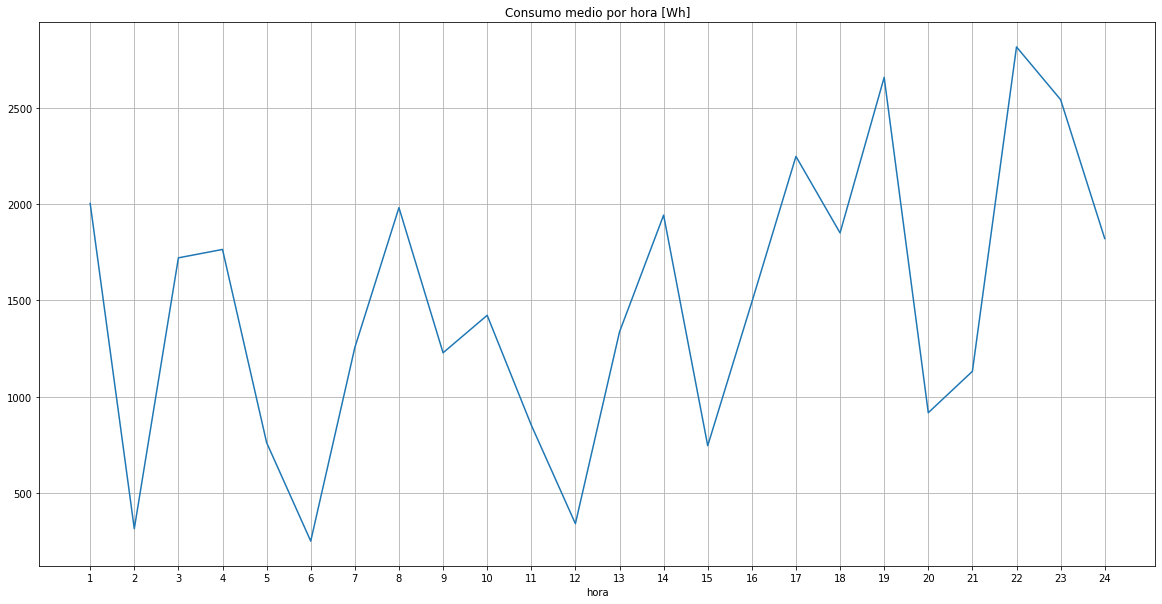

In [46]:
consumo_medio_hora.plot( 
    title='Consumo medio por hora [Wh]', 
    grid=True, kind="line", figsize=(20,10),
    xticks=[x for x in range(1, 25)])
#plt.plot(consumo_medio_hora.index, consumo_medio_hora.values)

## Cálculo de la producción de la instalación

Usamos la librería `pvlib` para relizar los cálculos. Se conecta con el sitio [web europeo de fotovoltáica](https://re.jrc.ec.europa.eu/pvg_tools/en/) (European Comission's JRC PHOTOVOLTAIC GEOGRAPHICAL INFORMATION SYSTEM) para obtener los datos. Ver también el proyecto [Solar Power](https://power.larc.nasa.gov/) de la NASA. El código está tomado del [artículo](https://towardsdatascience.com/solar-panel-power-generation-analysis-7011cc078900) de Leo van der Meulen.

In [53]:
def obtain_panel_power_data(lat, lon, start, end, name, tilt, azimuth, panels, peakpower):
    """
    Determine the solarradiation and generated power for a given solar panel configuration.
    For each hour between startdate and enddate the data is retrieved and calculated.
    :param lat: Latitude of the location
    :param lon: Longitude of the location
    :param start: Startdate for data retrievel
    :param end: Endddate for data retrievel
    :param name: Name of the panel location on the object
    :param tilt: Tilt of the solar panels (0 is flat, 90 is standing straight)
    :param azimuth: Direction the panels, 0 is South, negative from south to east, positive from south to west
    :param panels: Number of panels on the location
    :param peakpower: Peakpower per panel
    :return: dataframe 
    """
    if panels > 0:
        poa, meta, meta2 = pvlib.iotools.get_pvgis_hourly(
            latitude=lat, longitude=lon, start=start, end=end,
            surface_tilt=tilt, surface_azimuth=-azimuth,
            pvcalculation=True, peakpower=peakpower*panels,
            components=True, raddatabase='PVGIS-SARAH2', url='https://re.jrc.ec.europa.eu/api/v5_2/',
            )
    else:
        poa, meta, meta2 = pvlib.iotools.get_pvgis_hourly(
            latitude=lat, longitude=lon, start=start, end=end,
            surface_tilt=tilt, surface_azimuth=-azimuth,
            pvcalculation=False,
            components=True, raddatabase='PVGIS-SARAH2', url='https://re.jrc.ec.europa.eu/api/v5_2/',
            )
        poa['P'] = 0.0
    poa['date'] = pd.to_datetime(poa.index.date)
    poa['location'] = name
    poa['P'] = poa['P'].div(1000)    # change unit to kWh
    print(meta)
    print(meta2)
    return poa

In [54]:
# calculamos la generación.
data_panel_power=obtain_panel_power_data(lat, lon, start, end, name, tilt, azimut, panels, peakpower)

{'location': {'latitude': 38.908688333675734, 'longitude': 1.4240844998325475, 'elevation': 13.0}, 'meteo_data': {'radiation_db': 'PVGIS-SARAH2', 'meteo_db': 'ERA-Interim', 'year_min': 2020, 'year_max': 2020, 'use_horizon': True, 'horizon_db': None, 'horizon_data': 'DEM-calculated'}, 'mounting_system': {'fixed': {'slope': {'value': 30, 'optimal': False}, 'azimuth': {'value': 5, 'optimal': False}, 'type': 'free-standing'}}, 'pv_module': {'technology': 'c-Si', 'peak_power': 3.24, 'system_loss': 0.0}}
{'inputs': {'location': {'description': 'Selected location', 'variables': {'latitude': {'description': 'Latitude', 'units': 'decimal degree'}, 'longitude': {'description': 'Longitude', 'units': 'decimal degree'}, 'elevation': {'description': 'Elevation', 'units': 'm'}}}, 'meteo_data': {'description': 'Sources of meteorological data', 'variables': {'radiation_db': {'description': 'Solar radiation database'}, 'meteo_db': {'description': 'Database used for meteorological variables other than so

In [55]:
#for col in data_panel_power.columns:
#  print(col)

print(f"La radiación ha sido registrada en horario {data_panel_power.index.tz}, pasando a {zona_horaria}")

# el index es la fecha y hora en UTC, creamos una columna en CET para ajustar la hora
data_panel_power['timestamp_ajustado']=data_panel_power.index.tz_convert(CET)

# extraemos la hora y le sumamos 1 para hacerla compatible con el dataset de la compañía
data_panel_power['hora']=data_panel_power.timestamp_ajustado.dt.hour+1

# print(data_panel_power.head(10))

# seleccionamos las columnas de interés
pot_generada=data_panel_power[["date","hora", "P"]]

# seleccionamos el periodo
pot_generada_periodo=pot_generada[pot_generada['date']>=str_start]
pot_generada_periodo=pot_generada_periodo[pot_generada_periodo['date']<=str_fins]

#print(f'\nProducción media por hora [kWh] desde {str_start} hasta {str_fins}')
produccion_media_hora=pot_generada_periodo.groupby(["hora"])['P'].mean()*1000

#produccion_media_hora['produccion']=list(consumo_medio_hora.values)


#lista_datos=[pd.Series(produccion_media_hora.values, index=cols), pd.Series(consumo_medio_hora.values, index=cols)]
comparativa=pd.DataFrame(columns=['produccion', 'consumo'])#, 'diferencia'])

comparativa.produccion=produccion_media_hora.values
comparativa.consumo=consumo_medio_hora.values
#comparativa.diferencia=produccion_media_hora.values-consumo_medio_hora.values

#print(comparativa.head(28))



La radiación ha sido registrada en horario UTC, pasando a Europe/Madrid


## Gráfica de producción y consumo

Consumo medio/dia: 35.396 kWh


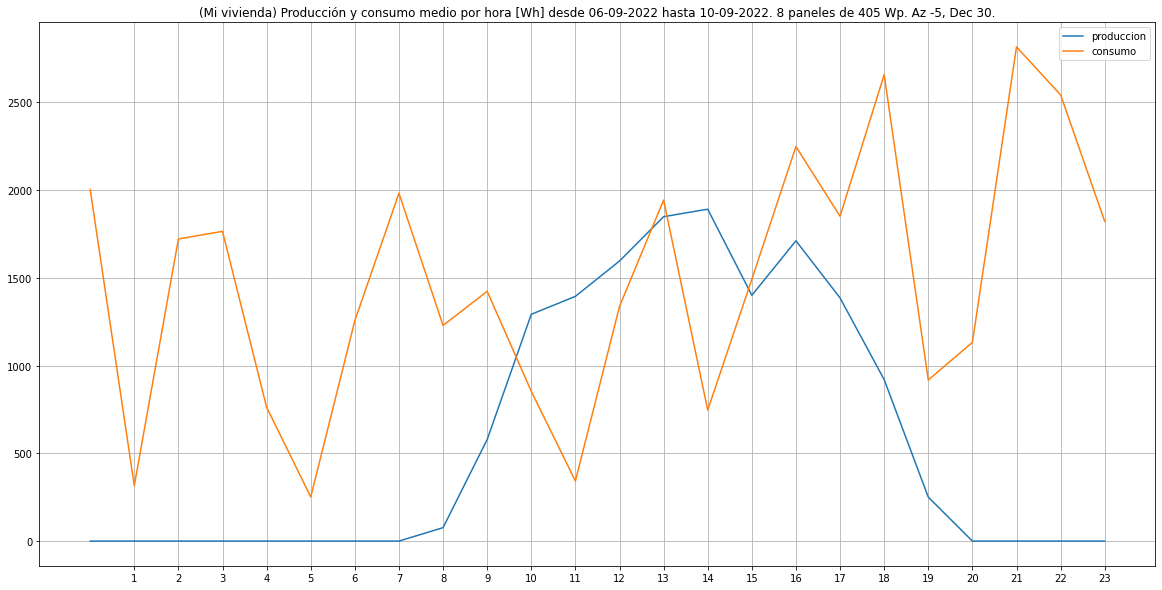

In [56]:
comparativa.plot(
    title=f'({name}) Producción y consumo medio por hora [Wh] desde {desde:%d-%m-%Y} hasta {fins:%d-%m-%Y}. {panels} paneles de {peakpower*1000:.0f} Wp. Az {azimut}, Dec {tilt}.', 
    grid=True, kind="line", figsize=(20,10),
    xticks=[x for x in range(1, 24)]
)

print(f'Consumo medio/dia: {(total_consumo/1000)/dias:.3f} kWh')

## Recursos


PVGIS Photovoltaic Geographical Information System

> European Commission. [PVGIS](https://joint-research-centre.ec.europa.eu/pvgis-photovoltaic-geographical-information-system_en)


Librería pvlib
> William F. Holmgren, Clifford W. Hansen, and Mark A. Mikofski. “pvlib python: a python package for modeling solar energy systems.” Journal of Open Source Software, 3(29), 884, (2018). https://doi.org/10.21105/joss.00884

The power project

> NASA. [https://power.larc.nasa.gov/](https://power.larc.nasa.gov/)

Solar panel power generation analysis

> Leo van der Meulen. "How much energy will you be able to generate with your solar panels? Make your own calculations to stay in control" Medium. [https://towardsdatascience.com/solar-panel-power-generation-analysis-7011cc078900](https://towardsdatascience.com/solar-panel-power-generation-analysis-7011cc078900)

Shadow Calculator

> KameoCode. "Sun position calculator on google maps.
Predict size of shadows at different times of the day for google maps location." [http://shadowcalculator.eu/](http://shadowcalculator.eu/)